# Import Libraries


In [2]:
!pip3 install pandas
!pip3 install numpy
!pip3 install mataplotlib
!pip3 install seaborn
!pip3 install sklearn
!pip3 install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, accuracy_score, recall_score, f1_score, average_precision_score

# Smote
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline

from sklearn.metrics import precision_recall_curve, auc
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, RandomizedSearchCV


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement mataplotlib (from versions: none)

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for mataplotlib

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use c

# Load and Explore the Dataset


In [10]:
# Load the dataset
df = pd.read_csv("creditcard.csv")

# Change the columm Class to Fraud
df.rename(columns={'Class': 'Fraud'}, inplace=True)

# Display first few rows
df.head()

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Debugging
# Display basic statistics
print("\nDataset Statistics:\n", df.describe())

# Check class distribution
print("\nClass Distribution:\n", df['Fraud'].value_counts())


Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Fraud     0
dtype: int64

Dataset Statistics:
                 Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.5

# Visualization of Dataset


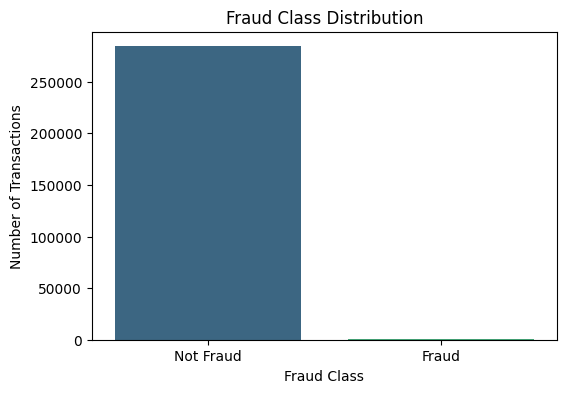

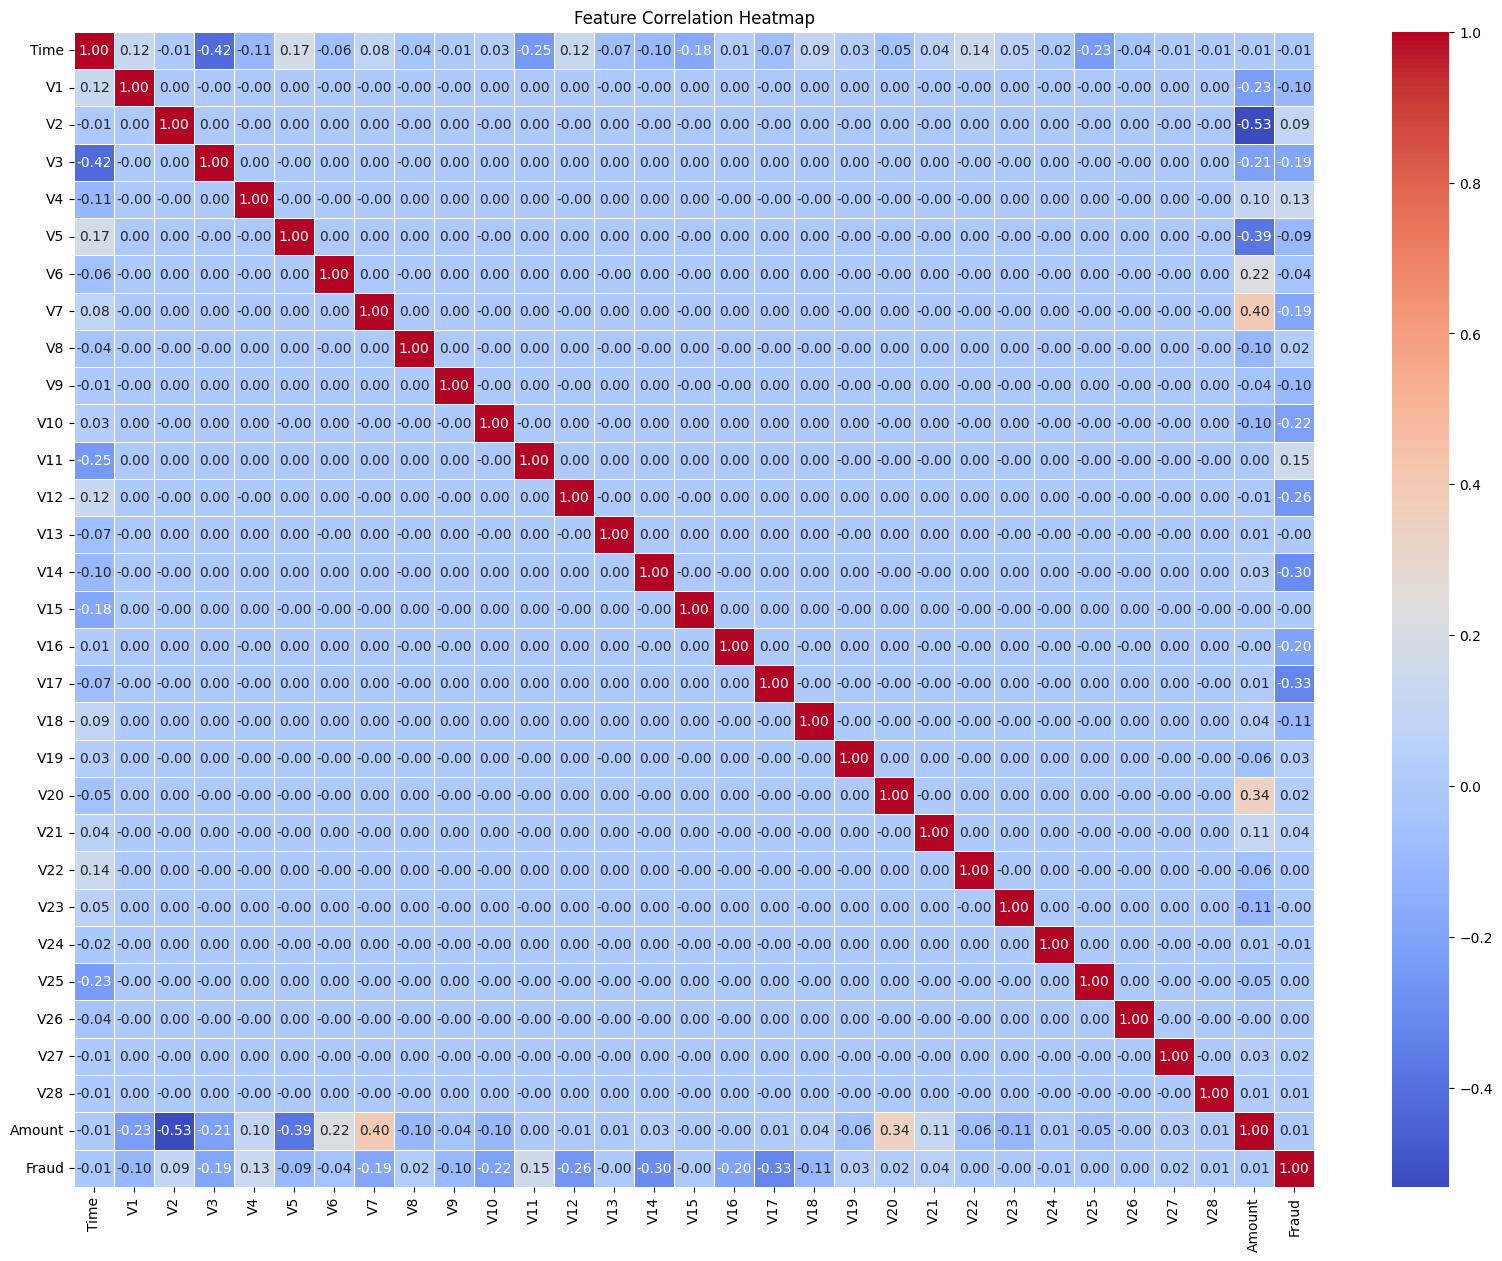

In [8]:
# Fraud Class Distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=df["Fraud"].value_counts().index,
            y=df["Fraud"].value_counts().values,
            hue=df["Fraud"].value_counts().index,
            palette="viridis",
            legend=False)

plt.xticks([0, 1], ["Not Fraud", "Fraud"])
plt.ylabel("Number of Transactions")
plt.xlabel("Fraud Class")
plt.title("Fraud Class Distribution")
plt.show()

# Select only numeric columns for correlation computation
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Feature Correlation Heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Outlier Removal

In [11]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = df['V14'].loc[df['Fraud'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

df = df.drop(df[(df['V14'] > v14_upper) | (df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = df['V12'].loc[df['Fraud'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
df = df.drop(df[(df['V12'] > v12_upper) | (df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(df)))
print('----' * 44)


# Removing outliers Feature
V4_fraud = df['V4'].loc[df['Fraud'] == 1].values
q25, q75 = np.percentile(V4_fraud, 25), np.percentile(V4_fraud, 75)
V4_iqr = q75 - q25

V4_cut_off = V4_iqr * 1.5
V4_lower, V4_upper = q25 - V4_cut_off, q75 + V4_cut_off
print('V4 Lower: {}'.format(V4_lower))
print('V4 Upper: {}'.format(V4_upper))
outliers = [x for x in V4_fraud if x < V4_lower or x > V4_upper]
print('V4 outliers: {}'.format(outliers))
print('Feature V4 Outliers for Fraud Cases: {}'.format(len(outliers)))
df = df.drop(df[(df['V4'] > V4_upper) | (df['V4'] < V4_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(df)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-19.2143254902614, -18.8220867423816, -18.4937733551053, -18.0499976898594]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.0475965708216, -18.6837146333443, -18.5536970096458, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 284506
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V4 Lower: -3.5689329354685535
V4 Upper: 12.171805988464309
V4 outliers: []
Feature V4 Outliers for 

# Data Preprocessing

Note from corr matrix
- We can see that V17, V14, V12, and V10 has a high correlation with Fraud class, meaning the higher values = more likely fraud
- We can see that V2, V4, V11, and V19 has a low correlation with Fraud class, meaning the lower values = more likely fraud

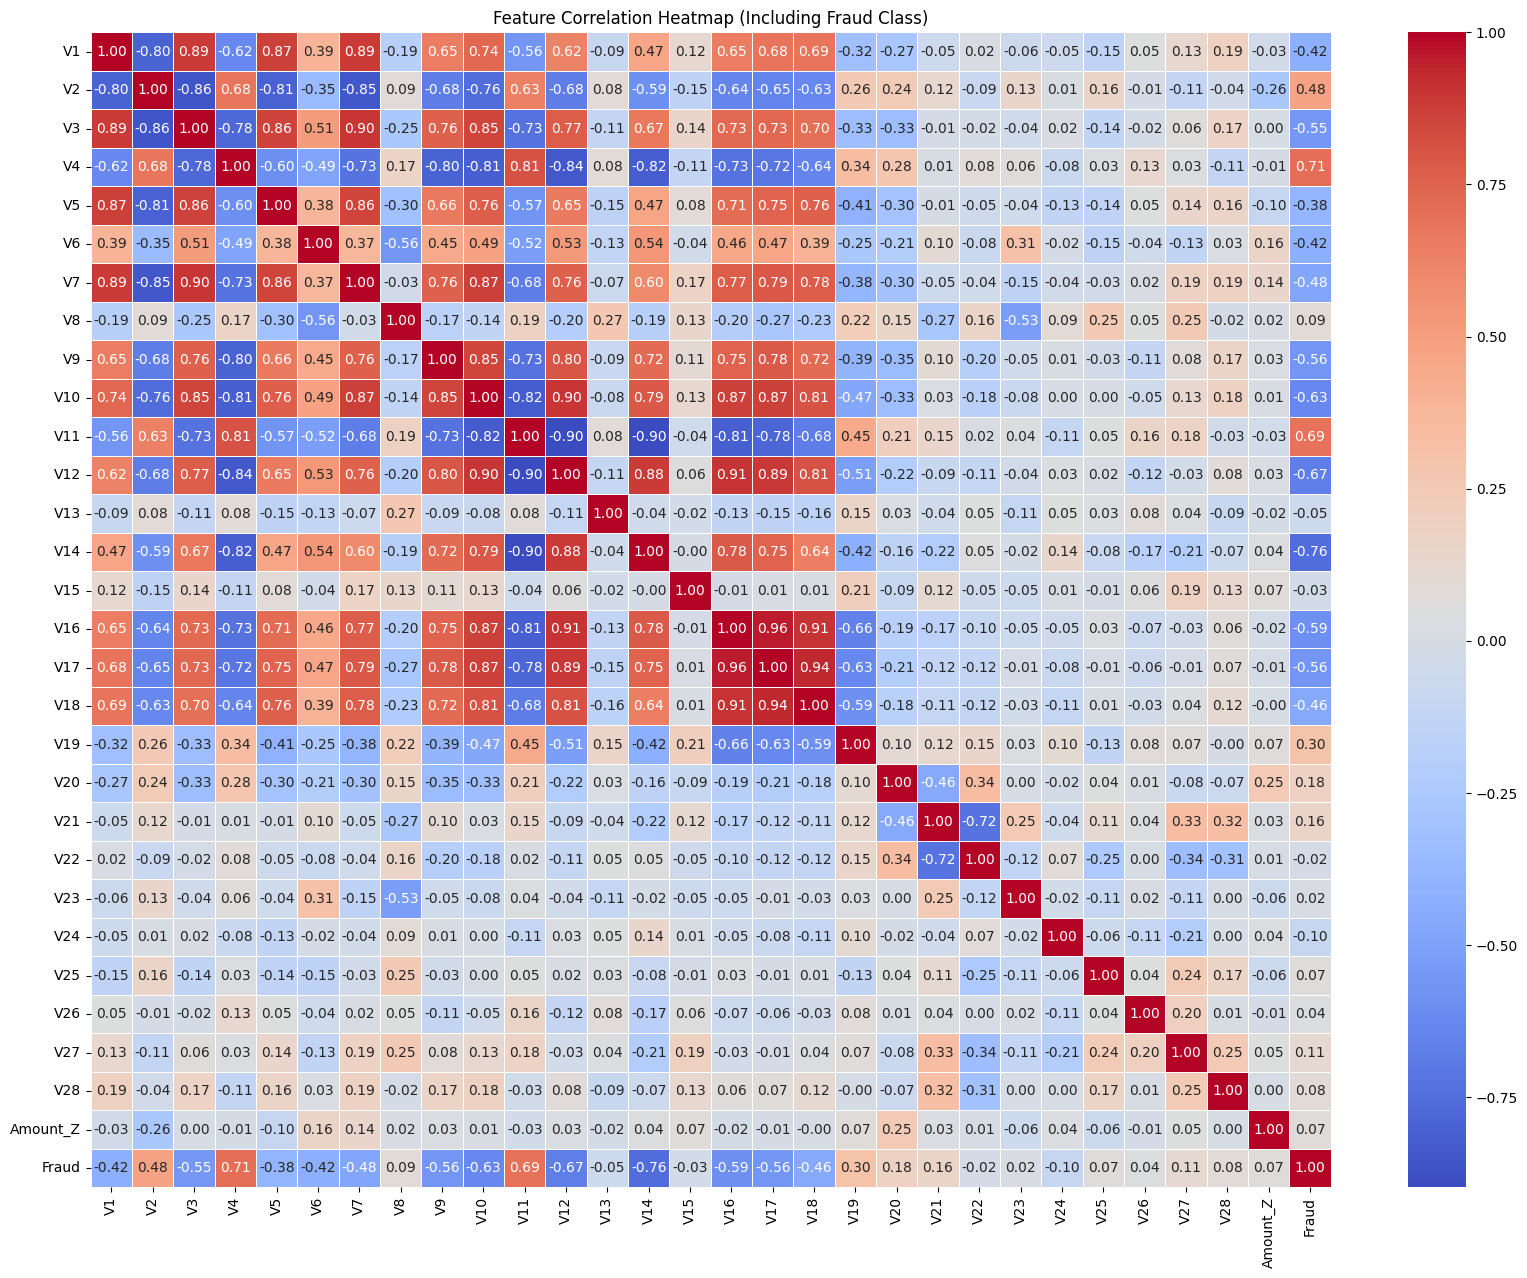

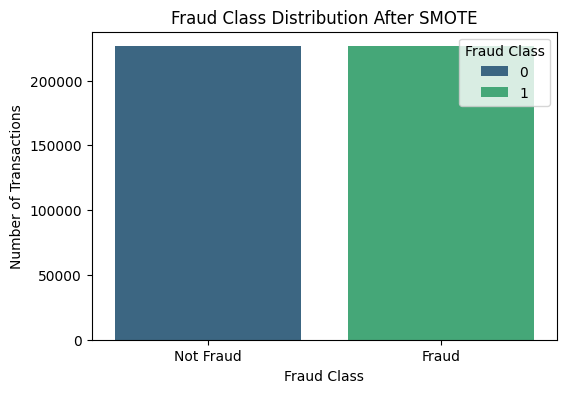

In [ ]:
# Feature Engineering 
# 1. Standardize Transaction Amount
scaler = StandardScaler()
df["Amount_Z"] = scaler.fit_transform(df[["Amount"]])

# Drop the original amount
df.drop(columns=["Amount", "Time"], inplace=True)

# Separate features and target variable
df = df.dropna(subset=['Fraud'])  # Remove rows where 'Fraud' is NaN
X = df.drop(columns=['Fraud'])
y = df['Fraud']

# Split data into training and testing sets
# Stratify is very important to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training set only
smote = SMOTE(sampling_strategy="minority", random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Convert to DataFrame for feature selection
X_train_sm = pd.DataFrame(X_train_sm, columns=X.columns)
y_train_sm = pd.Series(y_train_sm)

# Normalize features
X_train_sm = pd.DataFrame(scaler.fit_transform(X_train_sm), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Add Fraud column back for correlation analysis
X_train_sm['Fraud'] = y_train_sm

# Compute correlation matrix including Fraud
correlation_matrix = X_train_sm.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Including Fraud Class)")
plt.show()

# Drop Fraud column again for model training
X_train_sm = X_train_sm.drop(columns=['Fraud'])


# Fraud Class Distribution After SMOTE
plt.figure(figsize=(6, 4))
sns.barplot(x=y_train_sm.value_counts().index,
            y=y_train_sm.value_counts().values,
            hue=y_train_sm.value_counts().index,
            palette="viridis")

plt.xticks([0, 1], ["Not Fraud", "Fraud"])
plt.ylabel("Number of Transactions")
plt.xlabel("Fraud Class")
plt.title("Fraud Class Distribution After SMOTE")
plt.legend(title="Fraud Class")
plt.show()

# Anomaly Distros Plot Visualisation

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_22836\2228806296.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_22836\2228806296.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  

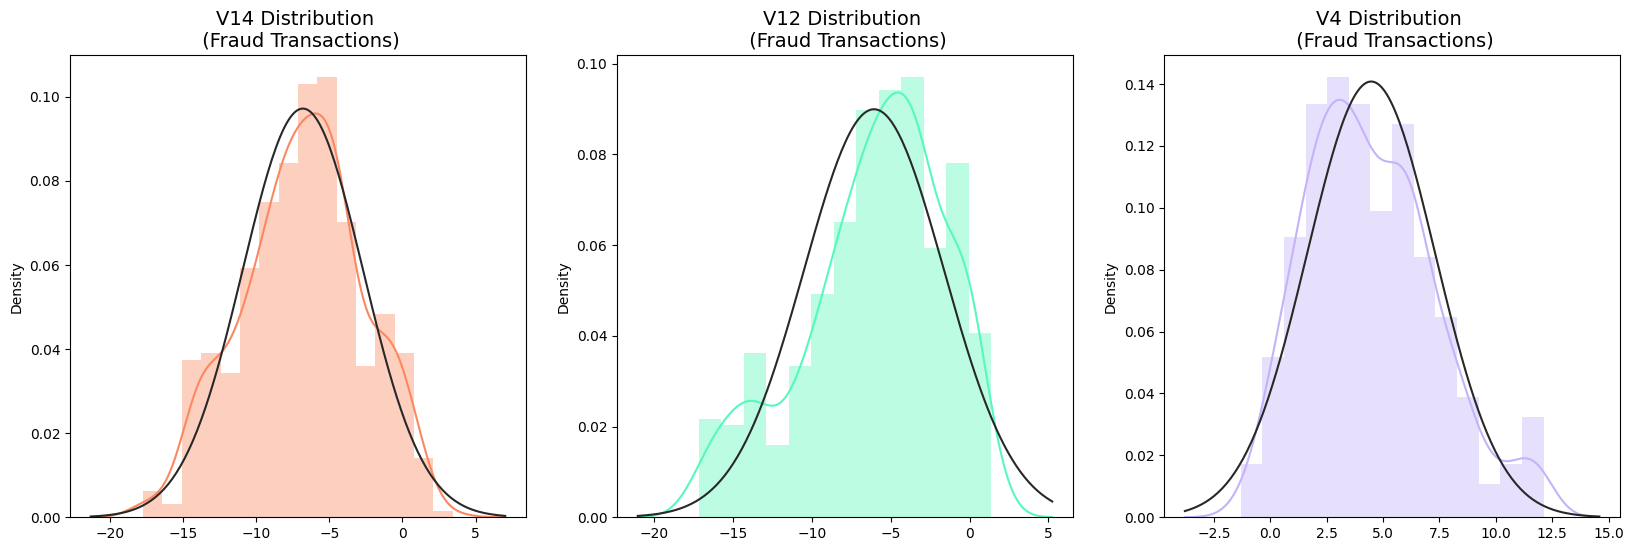

In [12]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = df['V14'].loc[df['Fraud'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = df['V12'].loc[df['Fraud'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = df['V4'].loc[df['Fraud'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V4 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

# RFE Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight="balanced")

# Create the pipeline
pipeline = make_pipeline(
    SMOTE(sampling_strategy='minority', random_state=42),  # Handles class imbalance
    RFECV(estimator=rf_model, cv=3, scoring="average_precision", verbose=2)
)

# Fit the pipeline on the data
pipeline.fit(X_train, y_train)

# Extract selected features from RFECV in the pipeline
selected_features_rfe = X_train.columns[pipeline.named_steps["rfecv"].get_support()]
print("RFE Selection Chosen Features:", selected_features_rfe.tolist())

# ------------------------
# Model Comparisons
# ------------------------

# Train Random Forest with all features
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Baseline metrics
baseline_accuracy = accuracy_score(y_test, y_pred)
baseline_recall_class1 = recall_score(y_test, y_pred, pos_label=1)

# Train with RFE-selected features
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

rf_model.fit(X_train_rfe, y_train)
y_pred_rfe = rf_model.predict(X_test_rfe)

# RFE-based metrics
rfe_accuracy = accuracy_score(y_test, y_pred_rfe)
rfe_recall_class1 = recall_score(y_test, y_pred_rfe, pos_label=1)

# ------------------------
# Print Results
# ------------------------

print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Baseline Class 1 Recall: {baseline_recall_class1:.4f}")
print(f"RFE Selection Accuracy: {rfe_accuracy:.4f}")
print(f"RFE Selection Class 1 Recall: {rfe_recall_class1:.4f}")


Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


# Hyperparameter Tuning

In [ ]:
# Reassign X_train_SMOTE to selected features
X_train_sm = X_train_sm[selected_features_rfe]


# Define the pipeline
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy="minority", random_state=42, k_neighbors=4)),  # Apply SMOTE inside the pipeline
    ('classifier', RandomForestClassifier(n_estimators=50, random_state=42, class_weight="balanced", n_jobs=-1))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__max_depth': [20, 30, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4 ],
    'classifier__max_features': ['sqrt', 'log2']
}

# # Define Stratified K-Fold cross-validation
stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Use HalvingGridSearchCV for faster tuning
halving_search = HalvingGridSearchCV(
    pipeline, param_grid, cv=stratified_cv, scoring='average_precision', factor=3, n_jobs=-1, verbose=1, random_state=42
)

# Fit the model with the normalized data
halving_search.fit(X_train, y_train)

# Get best parameters and retrain with full trees
best_params = halving_search.best_params_
best_params['n_estimators'] = 300  # Increase trees for final model

# Remove the 'classifier__' prefix from the best parameters
best_params = {key.replace('classifier__', ''): value for key, value in best_params.items()}

print("\nFitting Model")
# Now create a new pipeline with these final parameters
best_rf_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)

# Train the final model on the full data
best_rf_model.fit(X_train_sm, y_train_sm)

# Print final model score
print("Best Parameters:", best_params)
print("Final Model Accuracy:", best_rf_model.score(X_test, y_test))

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 8396
max_resources_: 226713
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 8396
Fitting 3 folds for each of 54 candidates, totalling 162 fits
----------
iter: 1
n_candidates: 18
n_resources: 25188
Fitting 3 folds for each of 18 candidates, totalling 54 fits
----------
iter: 2
n_candidates: 6
n_resources: 75564
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 3
n_candidates: 2
n_resources: 226692
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Fitting Model
Best Parameters: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Final Model Accuracy: 0.9994530602163059


# Model Evaluation


Best Threshold for F1-Score: 0.64

Random Forest Accuracy: 0.9996


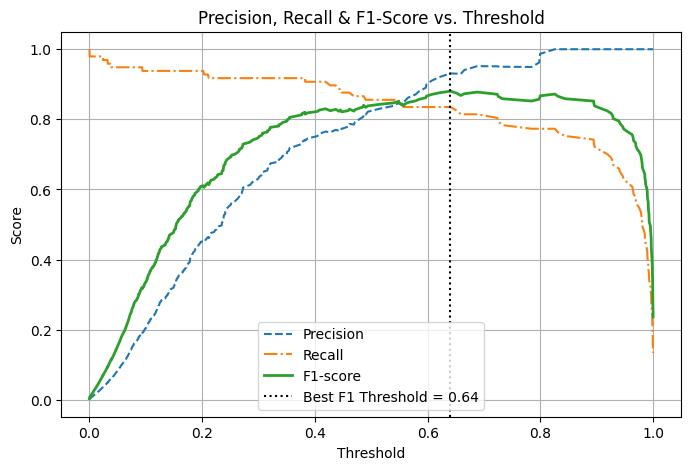


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56582
           1       0.93      0.84      0.88        97

    accuracy                           1.00     56679
   macro avg       0.97      0.92      0.94     56679
weighted avg       1.00      1.00      1.00     56679


Confusion Matrix:
[[56576     6]
 [   16    81]]

F1 Score: 0.88

Precision-Recall AUC Score: 0.90989310203707


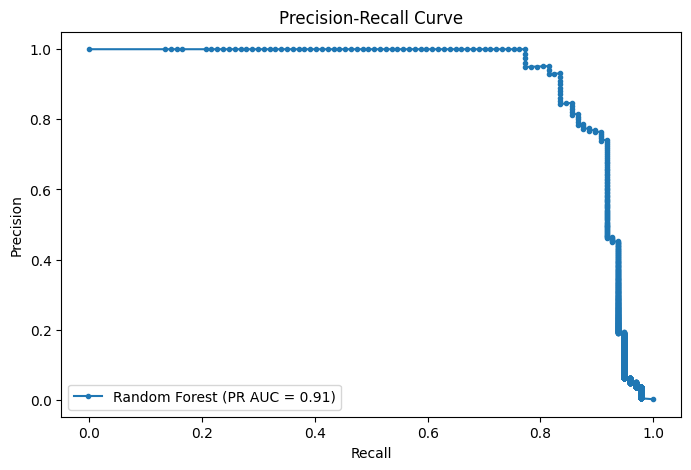

In [ ]:
# Model Evaluation
# Make Predictions
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]  # Get probability scores

# Compute Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Find Best Threshold (Maximizing F1-Score)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]

print(f"\nBest Threshold for F1-Score: {best_threshold:.2f}")

# Convert Probabilities into Binary Predictions Using Best Threshold
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_adjusted)

# Print accuracy
print(f"\nRandom Forest Accuracy: {accuracy:.4f}")

# Plot Precision-Recall vs. Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precision", linestyle="--")
plt.plot(thresholds, recall[:-1], label="Recall", linestyle="-.")
plt.plot(thresholds, f1_scores[:-1], label="F1-score", linestyle="-", linewidth=2)
plt.axvline(best_threshold, color='black', linestyle="dotted", label=f"Best F1 Threshold = {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall & F1-Score vs. Threshold")
plt.legend()
plt.grid()
plt.show()

# Apply New Threshold
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

# Evaluate Performance
print("\nClassification Report")
print(classification_report(y_test, y_pred_adjusted))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred_adjusted)
print(f"\nF1 Score: {f1:.2f}")

# Compute Precision-Recall AUC
pr_auc = auc(recall, precision)
print("\nPrecision-Recall AUC Score:", pr_auc)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label="Random Forest (PR AUC = {:.2f})".format(pr_auc))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# ROC Curve Visualization

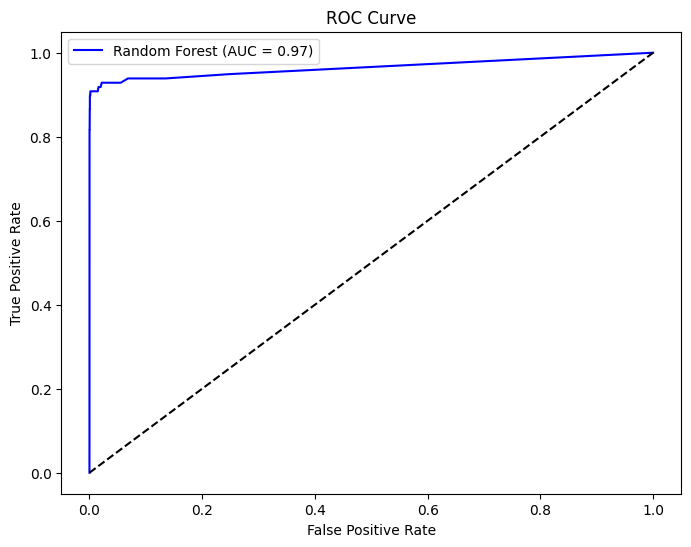

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="Random Forest (AUC = {:.2f})".format(roc_auc_score(y_test, y_pred_proba)), color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()